# Legal Document Classifier 

**Objective** 

A Natural Language Processing (NLP) pipeline that classifies legal case reports into specific areas of law

**Dataset Overview** 
A 200 rows csv file containing the following columns: 

- case_title – Title of the legal case 
- suitno – Suit number or case reference 
- introduction – Brief introduction (includes area of law) 
- facts – Summary of the facts of the case 
- issues – Legal issues considered in the case 
- decision – The decision or judgment 
- full_report – The full body of the legal judgment

**Solution**
- Built a traditional model
- Built a Transformer model
- Compare both models
- Deployed the Transformer model using FastApi

In [1]:
#import necessary libraries for data cleaning and also for both Traditional and Transfomer model training, then also for the result metrics

import pandas as pd
import numpy as np
import re
import html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix


# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# import torch
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from datasets import Dataset


from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder


import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('legal_docs.csv')

In [3]:
df.head(5)

,case_title,suitno,introduction,facts,issues,decision,full_report
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.\n,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri..."
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ..."
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le..."
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri..."


In [4]:
df.shape

(200, 7)

In [5]:
#checking for data type and null values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_title    200 non-null    object
 1   suitno        200 non-null    object
 2   introduction  200 non-null    object
 3   facts         200 non-null    object
 4   issues        199 non-null    object
 5   decision      200 non-null    object
 6   full_report   200 non-null    object
dtypes: object(7)
memory usage: 11.1+ KB


### Data Cleaning

In [6]:
# Strip whitespaces and decode HTML entities
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).strip()
    text = html.unescape(text)
    return text

# Apply cleaning to all text columns
text_columns = ['case_title', 'suitno', 'introduction', 'facts', 'issues', 'decision', 'full_report']
for col in text_columns:
    df[col] = df[col].apply(clean_text)


# Remove duplicates based on case_title and suitno
df_cleaned = df.drop_duplicates(subset=['case_title', 'suitno'])
df_cleaned.head()


,case_title,suitno,introduction,facts,issues,decision,full_report
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA OGUNTADE, J.C.A. (Delivering th..."
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",CHIOMA EGONDU NWOSU-IHEME J.C.A. (Delivering ...
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ..."
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le..."
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO OHO, J.C.A. (Delivering th..."


In [7]:
#checking for null value
df_cleaned.isna().sum()

case_title      0
suitno          0
introduction    0
facts           0
issues          0
decision        0
full_report     0
dtype: int64

In [8]:
#checking more details about the dataset
df_cleaned.describe()

,case_title,suitno,introduction,facts,issues,decision,full_report
count,200,200,200,200,200,200,200
unique,200,200,114,200,200,149,200
top,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court found no merit in the ...","GEORGE ADESOLA OGUNTADE, J.C.A. (Delivering th..."
freq,1,1,33,1,1,15,1


In [9]:
#exploring the column to be cleaned in preparation for training
df['full_report']

0      GEORGE ADESOLA OGUNTADE, J.C.A. (Delivering th...
1      CHIOMA EGONDU NWOSU-IHEME J.C.A.  (Delivering ...
2      PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...
3      IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le...
4      FREDERICK OZIAKPONO OHO, J.C.A. (Delivering th...
                             ...                        
195    MOHAMMED MUSTAPHA, J.C.A. (Delivering the Lead...
196    IBRAHIM TANKO MUHAMMAD, J.C.A. (Delivering the...
197    MUSLIM SULE HASSAN, J.C.A. (Delivering the Lea...
198    MOHAMMED MUSTAPHA, J.C.A. (Delivering the Lead...
199    VICTOR AIMEPOMO OYELEYE OMAGE, J.C.A. (Deliver...
Name: full_report, Length: 200, dtype: object

In [10]:
# Define cleaning function for full_report
def clean_full_report(text):
    if pd.isna(text):
        return ""
    
    # Decode HTML entities
    text = html.unescape(text)
    # Remove newlines and carriage returns
    text = text.replace("\n", " ").replace("\r", " ")
    # Remove judge delivery statements (e.g., "Delivering...")
    text = re.sub(r'\(\s*Delivering.*?judgment\s*\)', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\bJ\.C\.A\.\b', '', text)
    # Collapse multiple spaces into one
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [11]:
# Apply to DataFrame
df_cleaned['full_report'] = df_cleaned['full_report'].apply(clean_full_report)

In [12]:
df_cleaned['full_report'].head(5)

0    GEORGE ADESOLA OGUNTADE, J.C.A. : The appellan...
1    CHIOMA EGONDU NWOSU-IHEME J.C.A. (Delivering t...
2    PETER OYINKENIMIEMI AFFEN, J.C.A. : Introducti...
3    IBRAHIM SHATA BDLIYA, J.C.A. : This is an appe...
4    FREDERICK OZIAKPONO OHO, J.C.A. : This is an a...
Name: full_report, dtype: object

In [13]:
df_cleaned.shape

(200, 7)

In [14]:
df_cleaned.head(5)

,case_title,suitno,introduction,facts,issues,decision,full_report
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA OGUNTADE, J.C.A. : The appellan..."
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",CHIOMA EGONDU NWOSU-IHEME J.C.A. (Delivering t...
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. : Introducti..."
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.","IBRAHIM SHATA BDLIYA, J.C.A. : This is an appe..."
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO OHO, J.C.A. : This is an a..."


**Label Extraction from Introduction**

In [15]:
def extract_area_of_law(text):
    if pd.isna(text):
        return ""
    match = re.search(r'(?:borders on|ruling on an)\s+(.*?)(?:\.|\n)', text, re.IGNORECASE)
    return match.group(1).strip() if match else ""

df_cleaned['label'] = df_cleaned['introduction'].apply(extract_area_of_law)

#Standardization of label column
#Basic normalization (lowercase, strip, title-case)
df_cleaned['label'] = df_cleaned['label'].str.strip().str.lower().str.title()

In [16]:
(df_cleaned['label'].value_counts())

label
Civil Procedure                                                     42
Election Petition                                                   17
Land Law                                                            15
Criminal Law And Procedure                                           9
                                                                     4
                                                                    ..
Application For Bail Pending Appeal                                  1
Mortgage Law                                                         1
The Issue Of Locus Standi To Challenge A Political Party Primary     1
Award Of Damages                                                     1
Application On A Motion For Stay Of Proceedings                      1
Name: count, Length: 93, dtype: int64

In [17]:
#regroup the labels

label_corrections = {
    'The Enforcement Of Fundamental Right To Personal Liberty': 'The Enforcement Of Fundamental Human Rights',
    'Enforcement Of Fundamental Rights': 'Enforcement Of Fundamental Human Rights',
    'Enforcement Of Fundamental Right': 'Enforcement Of Fundamental Human Rights',
    'The Enforcement Of Fundamental Human Rights': 'Enforcement Of Fundamental Human Rights',
    'Contract': 'The Law Of Contract',
    'Enforcement Of Fundamental Rights': 'Enforcement of Fundamental Rights',
    'Pre-Election Matters': 'Election Petition', 'The Offence Of Acts Of Gross Indecency': 'Criminal Law and Procedure',
    'The Offence Of Culpable Homicide': 'Criminal Law and Procedure',
    'The Offence Of Culpable Homicide Punishable With Death': 'Criminal Law and Procedure',
    'The Offences Of Armed Robbery, Assault And Kidnapping': 'Criminal Law and Procedure',
    'The Offence Of Armed Robbery': 'Criminal Law and Procedure',
    'The Offence Of Murder': 'Criminal Law and Procedure',
    'The Offences Of Conspiracy To Murder And Attempt To Murder': 'Criminal Law and Procedure',
    'Offences Of Conspiracy And Armed Robbery': 'Criminal Law and Procedure',
    'Offences Of Conspiracy And Armed Robbery Appeal': 'Criminal Law and Procedure',
    'The Offence Of Rape': 'Criminal Law and Procedure',

    # Family Law
    'Judicial Separation/Dissolution Of Marriage': 'Family Law',
    'Dissolution Of Marriage': 'Family Law',

    # Property and Land Law
    'Land Matter': 'Property and Land Law',
    'Proof Of Title To Land': 'Property and Land Law',
    'Commercial Law': 'Property and Land Law',
    'Conveyancy Law': 'Property and Land Law',
    'The Law Of Mortgage': 'Property and Land Law',
    'Mortgage Law': 'Property and Land Law',
    'Lease Agreement': 'Property and Land Law',
    'Contract Of Sale Of Property': 'Property and Land Law',
    'Tenancy Contract': 'Property and Land Law',
    'Order Of Forfeiture': 'Property and Land Law',
    'Declaration Of Title To Land': 'Property and Land Law',
    'Land Law': 'Property and Land Law',
    'Administration Of Estate':'Property and Land Law',

    # Constitutional & Human Rights Law
    'The Enforcement Of Fundamental Rights': 'Enforcement Of Fundamental Human Rights',
    'The Enforcement Of Fundamental Right To Personal Liberty': 'Enforcement Of Fundamental Human Rights',
    'Enforcement Of Fundamental Right To Liberty': 'Enforcement Of Fundamental Human Rights',
    'Enforcement Of Fundamental Rights': 'Enforcement Of Fundamental Human Rights',
    'Equitable Remedy': 'Enforcement Of Fundamental Human Rights',
    'Islamic Law And Procedure': 'Constitutional & Religious Law', 'Inheritance Matters Under The Islamic Personal Law':'Constitutional & Religious Law',
    'Inheritances Matters Under The Islamic Personal Law': 'Constitutional & Religious Law',

    # Contract and Commercial Law
    'Recovery Of Premises': 'Contract and Commercial Law',
    'Banker-Customer Relationship': 'Contract and Commercial Law',
    'A Loan Contract': 'Contract and Commercial Law',
    'The Tort Of Negligence': 'Contract and Commercial Law',
    'The Interpretation Of The Doctrine Of Lis Pendens': 'Contract and Commercial Law',
    'Application Seeking Leave To Add Further Evidence On Appeal': 'Contract and Commercial Law',
    'Contract': 'Contract and Commercial Law',
    'Law Of Contract': 'Contract and Commercial Law',
    'The Law Of Contract': 'Contract and Commercial Law',
    'Action For Money Had And Received': 'Contract and Commercial Law',
    'Defamation': 'Contract and Commercial Law',

    # Civil Procedure
    'Application For Stay Of Execution Of Judgment': 'Civil Procedure',
    'Application Seeking A Restraining Order': 'Civil Procedure',
    'Application For Order Of Injunction': 'Civil Procedure',
    'Summary Judgment Procedure': 'Civil Procedure',
    'The Effect Of An Unsigned Statement Of Claim': 'Civil Procedure',
    'Application For Trinity Prayers': 'Civil Procedure',
    'Application Seeking Leave Of Court To Substitute Parties': 'Civil Procedure',
    'Application For Extension Of Time': 'Civil Procedure',
    'Application For Extension Of Time To File Notice Of Cross Appeal': 'Civil Procedure',
    'Application Seeking Leave To Appeal As An Interested Party': 'Civil Procedure',
    'No Case Submission': 'Civil Procedure',
    'A Defective Notice Of Appeal': 'Civil Procedure',
    'Application For Joinder Of Parties': 'Civil Procedure',
    'Application Seeking Leave To Add Parties': 'Civil Procedure',
    'Electoral Matters': 'Civil Procedure',
    'Setting Aside Of Interim Forfeiture Order': 'Civil Procedure',
    'The Issue Of Jurisdiction': 'Civil Procedure',
    'Jurisdiction Of Court': 'Civil Procedure',
    'The Jurisdiction Of The Federal/State High Court': 'Civil Procedure',
    'The Jurisdiction Of The Sharia Court Of Appeal': 'Civil Procedure',
    'Chieftaincy Matters': 'Civil Procedure',
    'Application For Extension Of Time To Appeal': 'Civil Procedure',
    'Service Of Court Process': 'Civil Procedure',
    'Jurisdiction Of The Federal High Court': 'Civil Procedure',
    'The Effect Of An Unsigned Statement Of Claim': 'Civil Procedure',
    'Application Seeking A Restraining Order Amongst Other Reliefs': 'Civil Procedure',
    'The Grant Of Injunction': 'Civil Procedure',
    'Application Seeking Leave To Adduce Further Evidence On Appeal': 'Civil Procedure',
    'An Application For An Order Of Mareva Injunction': 'Civil Procedure',
    'Application For Bail Pending Appeal': 'Civil Procedure',
    'Application On A Motion For Stay Of Proceedings': 'Civil Procedure',
    'Grant Of Interlocutory Injunction': 'Civil Procedure',

    # Tort Law
    'Tort Of Indebtedness': 'Tort Law',
    'Tort Of Trespass': 'Tort Law',
    'Tort Law':'Tort Law',
    
      # Arbitration
    'Arbitration And Conciliation': 'Arbitration',
    'Arbitration': 'Arbitration',

    # Evidence Law
    'Admissibility Of Evidence': 'Evidence Law',

    # Labour Law
    'Labour Law': 'Labour Law',

    # Election Petition
    'The Competence Of Joint Reply Where The Reply Of One Of The Parties Is Filed Out Of Time In An Election Petition': 'Election Petition',
    'Pre-Election Matters': 'Election Petition',
    'The Competence Of Joint Reply Where The Reply Of One Of The Parties Is Filed Out Of Time In An Election Petition': 'Election Petition',
    'Application Seeking Leave Of Court To Substitute Parties; Leave To Join Parties And Extension Of Time Within Which To File Notice And Grounds Of Appeal':'Election Petition',

    # Miscellaneous / Legal Doctrines
    'Capacity To Sue And Be Sued': 'Legal Doctrines',
    'Limitation Of Action': 'Legal Doctrines',
    'Doctrine Of Laches And Acquiescence': 'Legal Doctrines',
    'Proof Of Indebtedness': 'Legal Doctrines',
    'Limitation Law': 'Legal Doctrines',
    'The Interpretation Of The Doctrine Of Lis Pendens': 'Legal Doctrines',
    'The Issue Of Locus Standi To Challenge A Political Party Primary': 'Legal Doctrines',
    'Propriety Of Requirement Of Consent Of The A': 'Legal Doctrines',
}

#apply the regrouped labels to the dataset
df_cleaned['label'] = df_cleaned['label'].map(label_corrections).fillna(df_cleaned['label'])
df_cleaned = df_cleaned[df_cleaned['label'] != ""]

In [18]:
label_counts = df_cleaned['label'].value_counts()
valid_labels = label_counts[label_counts == 1].index

In [19]:
valid_labels

Index(['Award Of Damages', 'An Application  For An Order Of Mareva Injunction',
       'Application', 'Evidence Law',
       'The Interpretation Of The Doctrine Of Lis Pendes', 'Tort Law',
       'The Effect Of  An Unsigned  Statement Of Claim'],
      dtype='object', name='label')

### Training a Traditional Model
**Logistic Regression**

In [20]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df_cleaned['full_report'])
y = df_cleaned['label']

# Non-stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [22]:
# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

In [23]:
accuracy, f1, conf_matrix

(0.625,
 0.5293506493506493,
 array([[15,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 2,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 3,  0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  1,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  1,  0,  0,  0,  0],
        [ 2,  0,  0,  0,  0,  4,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  5]], dtype=int64))

## Transformer based model

In [26]:
# Tokenizer and Model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Encode labels
label_encoder = LabelEncoder()

df_cleaned.loc[:, "label_id"] = label_encoder.fit_transform(df_cleaned["label"])


# Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_cleaned["full_report"].tolist(),
    df_cleaned["label_id"].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')

In [27]:
# Define a custom PyTorch Dataset class to handle tokenized legal text inputs and their corresponding labels.
# This class supports indexing and batching for training and validation using a DataLoader.
# It returns input_ids, attention_mask, and labels for each data point.


class LegalDataset(Dataset):
    def __init__(self, encodings, labels):
        # Store the tokenized input data and convert labels to tensor
        self.encodings = encodings
        self.labels = torch.tensor(labels)
    
    def __getitem__(self, idx):
        # Retrieve a single data point including input_ids, attention_mask, and label
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

    # Create training and validation dataset instances
train_dataset = LegalDataset(train_encodings, train_labels)
val_dataset = LegalDataset(val_encodings, val_labels)

# Wrap datasets with DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [28]:
# Load pretrained DistilBERT model with a randomly initialized classification head
# The warning below is expected — classifier weights will be trained on our dataset.

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))
device = torch.device("cpu")
model.to(device)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Fine-tuning loop for the transformer model using training data.
# For each epoch, it iterates through the DataLoader batches:
# - Moves input tensors to the specified device (CPU/GPU)
# - Performs a forward pass to get loss
# - Backpropagates the loss
# - Updates model weights using the optimizer



# tqdm is used to show a progress bar for each epoch
from tqdm import tqdm

epochs = 2

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [04:59<00:00,  7.69s/it]


Epoch 1 - Training Loss: 2.5221


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [04:48<00:00,  7.40s/it]

Epoch 2 - Training Loss: 2.2414


In [30]:
# Evaluation loop for the transformer model on the validation dataset.

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



# Get only the label ids used in val set
unique_labels = np.unique(np.concatenate([all_labels, all_preds]))

# Get class names for those ids
class_names = label_encoder.inverse_transform(unique_labels)


# Print report
print(classification_report(all_labels, all_preds, labels=unique_labels, zero_division=0, target_names=class_names))


                                precision    recall  f1-score   support

               Civil Procedure       0.40      1.00      0.57        16
Constitutional & Religious Law       0.00      0.00      0.00         2
   Contract and Commercial Law       0.00      0.00      0.00         4
    Criminal Law And Procedure       0.00      0.00      0.00         1
    Criminal Law and Procedure       0.00      0.00      0.00         3
             Election Petition       0.00      0.00      0.00         6
                    Family Law       0.00      0.00      0.00         1
               Legal Doctrines       0.00      0.00      0.00         2
         Property and Land Law       0.00      0.00      0.00         5

                      accuracy                           0.40        40
                     macro avg       0.04      0.11      0.06        40
                  weighted avg       0.16      0.40      0.23        40



Accuracy: 0.4000
F1 Score (weighted): 0.2286

Classification Report:
                                precision    recall  f1-score   support

               Civil Procedure       0.40      1.00      0.57        16
Constitutional & Religious Law       0.00      0.00      0.00         2
   Contract and Commercial Law       0.00      0.00      0.00         4
    Criminal Law And Procedure       0.00      0.00      0.00         1
    Criminal Law and Procedure       0.00      0.00      0.00         3
             Election Petition       0.00      0.00      0.00         6
                    Family Law       0.00      0.00      0.00         1
               Legal Doctrines       0.00      0.00      0.00         2
         Property and Land Law       0.00      0.00      0.00         5

                      accuracy                           0.40        40
                     macro avg       0.04      0.11      0.06        40
                  weighted avg       0.16      0.40      0.23    

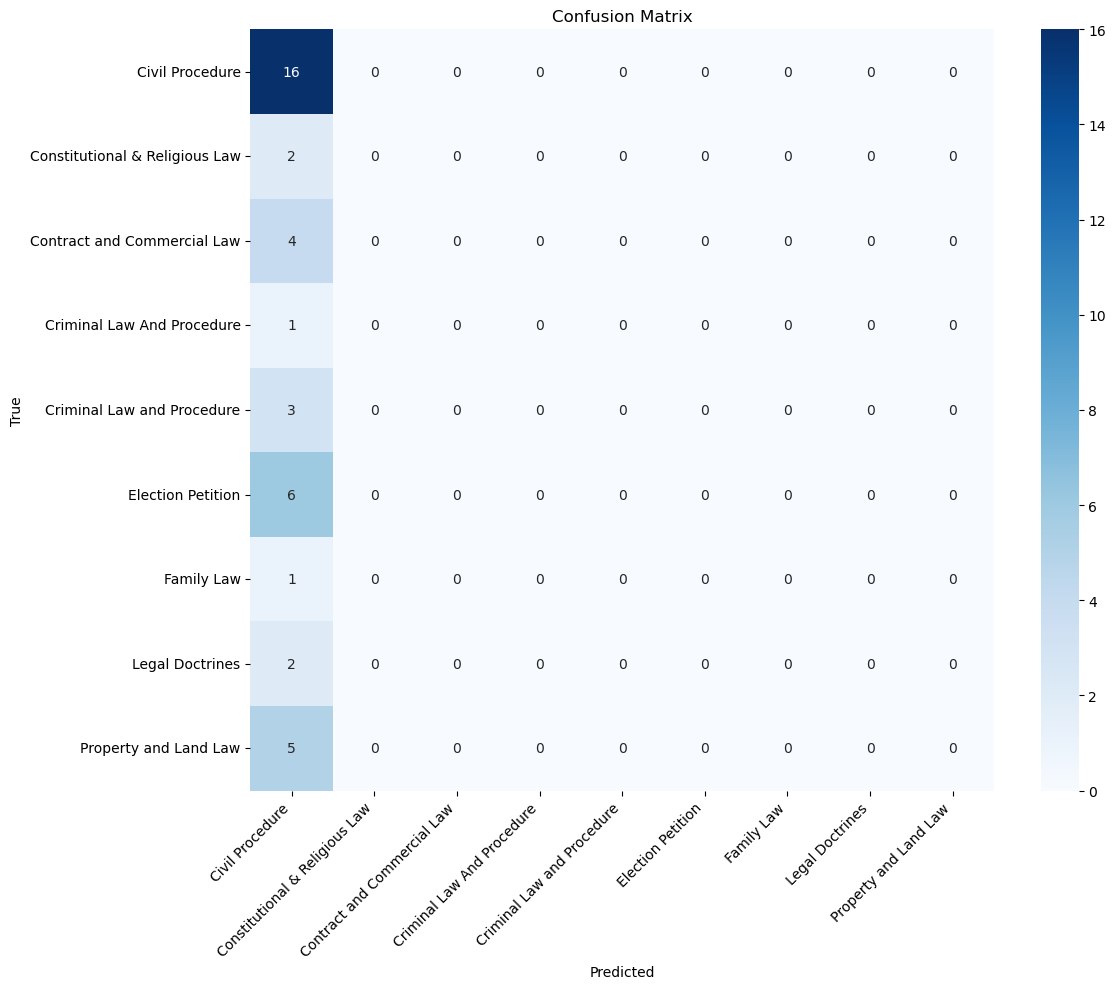

In [39]:
# Accuracy and F1
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Classification Report
print("\nClassification Report:")

# Get only the unique label IDs present in predictions and labels
unique_label_ids = np.unique(np.concatenate([all_labels, all_preds]))
class_names = label_encoder.inverse_transform(unique_label_ids)

# Print report using only those class names
print(classification_report(all_labels, all_preds, labels=unique_label_ids, zero_division=0, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_label_ids)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
save_directory = "models"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

import joblib
joblib.dump(label_encoder, f"{save_directory}/saved_model.pkl")